In [1]:
# default_exp data.load

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
import orjson

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 


In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
# export
class TSMulti(MultiTuple):pass

In [7]:
# export
def get_df(length = [100,120]):
    dct = {'x':[],'con_ts_1':[],'con_ts_0':[],'cat_ts_1':[],'cat_ts_0':[],'con_0':[],'con_1':[], 'cat_0':[],'cat_1':[]}
    for i, l in enumerate(length):
        assert int(l/2) == l/2
        dct['x'].append(np.arange(l))
        dct['con_ts_0'].append(np.ones(l)[None,:])
        dct['con_ts_1'].append(pd.Series(np.arange(l)+np.random.randn(l)))
        dct['con_0'].append(np.random.randn())
        dct['con_1'].append(10+np.random.randn()*2)
        dct['cat_ts_0'].append(L(['a','b']*int(l/2)))
        dct['cat_ts_1'].append(L(['david','john']*int(l/2)))
        dct['cat_0'].append(['a','b'][i%2])
        dct['cat_1'].append(['adam','rdam'][i%2])
    return pd.DataFrame(data=dct)
df = get_df([10,12,6])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 1.496443 1 2.682727 2 -0.091052 3 1.486127 4 2.801611 5 4.624926 6 7.045544 7 6.606412 8 7.011092 9 9.926540 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b]",-0.254046,10.495612,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 -1.133778 1 1.413521 2 1.649783 3 2.371874 4 4.117236 5 5.520095 6 7.232885 7 6.846127 8 5.385633 9 7.393246 10 9.931124 11 9.887198 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b]",1.634952,10.209572,b,rdam
2,"[0, 1, 2, 3, 4, 5]",0 0.727755 1 0.584449 2 2.727031 3 3.705124 4 3.759123 5 5.442429 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john]","[a, b, a, b, a, b]",0.301279,8.336852,a,adam


In [8]:
# export
import json
def python_type(o):
    if isinstance(o,int) or type(o) == np.int64:
        return int(o)
    elif isinstance(o,float) or type(o) == np.float64:
        if int(o) == o:
            return int(o)
        return float(o)
    elif type(o) == str:
        return o
    elif type(o) == pd.Series:
        return [python_type(v) for k,v in dict(o).items()]
    elif isinstance(o,list) or isinstance(o,L):
        return [python_type(v) for v in o]
    elif isinstance(o,np.ndarray):
        return [python_type(v) for v in list(o.flatten())]
    raise Exception(f"{type(o)}, {o}")
    
def _check_length(lst, length):    
    if length is None:
        length = len(lst)
    else:
        assert len(lst) == length
    return length
        
def reconize_cols(datapoint:dict, con_names= [], cat_names=[], ts_con_names=[], ts_cat_names=[]):
    """Gets the con_names, cat_names, ts_con_names, ts_cat_names for the `datapoint`"""
    length = None
    classes = {}
    for k,v in datapoint.items():
        if k in [con_names+cat_names+ ts_con_names+ts_cat_names]:
            if k in [cat_names+ts_cat_names]:
                classes[k] = list(set(v))
            continue
        if type(v) == int or isinstance(v,float):
            con_names.append(k)
        elif type(v) == str:
            cat_names.append(k)
            classes[k] = [v]
        elif isinstance(v,list) and (type(v[0]) == int or type(v[0]) == float):
            ts_con_names.append(k)
            length = _check_length(v, length)
        elif isinstance(v, list) and (type(v[0]) == str):
            ts_cat_names.append(k)
            length = _check_length(v, length)
            classes[k] = list(set(v))
        else:
            raise TypeError(type(v), type(v[0]))
    return length, classes, [list(set(o)) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]

def make_compact(dp, con_names, cat_names, ts_con_names, ts_cat_names, **kwargs):
    r = {'_'+k:v for k,v in kwargs.items()}
    r['con'] = [dp[k] for k in con_names]
    r['cat'] = [dp[k] for k in cat_names]
    r['ts_con'] = [[float(i) for i in dp[k]] for k in ts_con_names]
    r['ts_cat'] = [dp[k] for k in ts_cat_names]
    r['_col_names'] = {k:v for k,v in zip('con_names, cat_names, ts_con_names, ts_cat_names'.split(', '),
                                         [con_names, cat_names, ts_con_names, ts_cat_names],)}    
    return r

@delegates(reconize_cols)
def save_row(row, path:Path, fname='1', **kwargs):
    if not path.exists(): path.mkdir()
    if fname[-5:] is not '.json': fname += '.json'
    o = {k:python_type(v) for k,v in dict(row).items()}   
    length, classes, names = reconize_cols(o, **kwargs)  
    o = make_compact(o, *names, length = length, classes=classes)
    open(path / fname,'wb').write(orjson.dumps(o, ))
    return path / fname

def get_ts_datapoint(f):
    return orjson.loads(open(f,'rb').read())

In [9]:
df = get_df([6])
f = save_row(df.iloc[0,:], Path('../data/test_data'))
get_ts_datapoint(Path('../data/test_data') / '1.json')

{'_length': 6,
 '_classes': {'cat_ts_1': ['david', 'john'],
  'cat_ts_0': ['a', 'b'],
  'cat_0': ['a'],
  'cat_1': ['adam']},
 'con': [7.452480253204353, 1.6806546267421048],
 'cat': ['adam', 'a'],
 'ts_con': [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [-0.8085673996383703,
   2.4219441596825737,
   1.875365080282403,
   2.2769856203552212,
   3.9976291944583355,
   6.361136718317249],
  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]],
 'ts_cat': [['david', 'john', 'david', 'john', 'david', 'john'],
  ['a', 'b', 'a', 'b', 'a', 'b']],
 '_col_names': {'con_names': ['con_1', 'con_0'],
  'cat_names': ['cat_1', 'cat_0'],
  'ts_con_names': ['con_ts_0', 'con_ts_1', 'x'],
  'ts_cat_names': ['cat_ts_1', 'cat_ts_0']}}

In [10]:
# export
@delegates(save_row)
def save_df(df:pd.DataFrame, path:Path, **kwargs):
    for i, row in df.iterrows():
        save_row(row, path, fname=str(i), **kwargs)

In [11]:
df = get_df([600, 888, 1200, 2000])
path = Path('../data/test_data')
save_df(df, path)
[get_ts_datapoint(str(path / (str(i) + '.json'))).keys() for i in range(1,4)]

[dict_keys(['_length', '_classes', 'con', 'cat', 'ts_con', 'ts_cat', '_col_names']),
 dict_keys(['_length', '_classes', 'con', 'cat', 'ts_con', 'ts_cat', '_col_names']),
 dict_keys(['_length', '_classes', 'con', 'cat', 'ts_con', 'ts_cat', '_col_names'])]

## Transform catagorical data

In [12]:
# export
class TensorCatI(TensorBase):pass
class CatSeqI(TensorSeq):pass
def unpack_list(o, r=None):
    r = ifnone(r,L())
    for a in o:
        if isinstance(a,list) or isinstance(a,L):
            r = unpack_list(a, r)
        else:
            r.append(a)
    return r
            
class CatTfm(Transform):
    def __init__(self, df:pd.DataFrame = None, cat_cols:[] = None,
                 classes = None, vocab=None, o2i=None):
        if vocab is not None and o2i is not None:
            self.vocab,self.o2i = vocab, o2i
            return
        self.vocab,self.o2i = {},{}
        classes = ifnone(classes, {})
        if classes == {}:
            for col in cat_cols:
                classes[col] = unpack_list(list(df[col]))
        for col, vals in classes.items():
            self.vocab[col], self.o2i[col] = uniqueify(vals, sort=True, bidir=True)
            
    def encodes(self, x:TensorCat):
        r = []
        for i, (o, key) in enumerate(zip(x.o, x._meta['label'])):
            r.append(self.o2i[key][o])#TensorCat   
        return TensorCatI(r, label = x._meta['label'])
    
    def decodes(self, x:TensorCatI): 
        r = []
        for i,(o, key) in enumerate(zip(x,x._meta['label'])):
            r.append(self.vocab[key][o]) #TensorCat   
        return TensorCat(r, label = x._meta['label'])
    
    def encodes(self, x:CatSeq):
        r = []
        for i,(o, key) in enumerate(zip(x.o,x._meta['label'])):
            r.append([])
            for a in o: 
                r[i].append(self.o2i[key][a]) #CatSeq        
        return CatSeqI(r, label = x._meta['label'])
    
    def decodes(self, x:CatSeqI):
        r = []        
        for i, (o, key) in enumerate(zip(x,x._meta['label'])):
            r.append([])
            for a in o:
                r[i].append(self.vocab[key][a])  
        return CatSeq(r, label = x._meta.get('label',None))
    
    

In [13]:
o = CatSeq([['y','z','z','z'],['adam','rdam','adam','rdam']], label = ['cat_ts_1', 'cat_ts_0'])
df = pd.DataFrame({'cat_ts_1':[[i] for i in 'xzy'],'cat_ts_0':[[i] for i in ['adam','rdam','adam']],
                   'cat':['john','john','david'], 'cat1':['_john','_john','_david']})
tmf = CatTfm(df, ['cat_ts_0','cat_ts_1','cat','cat1'])
tmf(o)
o = TensorCat(['david','_john'], label = ['cat','cat1'])
tmf(o)


TensorCatI([0, 1])

In [14]:
df = pd.DataFrame({'a':[[i,'a'] for i in 'aabb']})
tmf = CatTfm(df, ['a'], {})
print(tmf.vocab)

{'a': (#2) ['a','b']}


In [15]:
o = CatSeq([['a','b','a','a']], label='a')
o_tmf = tmf(o)
test_eq(o_tmf, TensorCatI([[0, 1, 0, 0]]))
test_eq(o_tmf._meta['label'], 'a')
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeq([['a', 'b', 'a', 'a']], label = ['a'])

In [16]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a'], label='a'))
test_eq_type(o_tmf,TensorCatI([0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a'],label = 'a'))

o_tmf = tmf(TensorCat(['b'], label='a'))
test_eq_type(o_tmf,TensorCatI([1]))
test_eq(tmf.decode(o_tmf),TensorCat(['b'],label='a'))

In [17]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b'], label = ['a','a_2']))
test_eq_type(o_tmf,TensorCatI([0,0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b'],label = 'a'))

In [18]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o = CatSeq([['a','b','a','a'],['b','b','c','c']], label=['a','a_2'])
o_tmf = tmf(o)
print(o_tmf)
test_eq(o_tmf, CatSeqI([[0, 1, 0, 0],
                        [0, 0, 1, 1]]))
test_eq(o_tmf._meta['label'], ['a','a_2'])
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeqI([[0, 1, 0, 0],
        [0, 0, 1, 1]])


CatSeq([['a', 'b', 'a', 'a'], ['b', 'b', 'c', 'c']], label = ['a', 'a_2'])

In [19]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, **kwargs): # maybe change to proccs
        self.f = CatTfm( **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [20]:
df = get_df([14,14])
tmf = CatMultiTfm(df= df,cat_cols=['cat_ts_1', 'cat_ts_0', 'cat_0','cat_1'])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0 -0.408691 1 -0.554316 2 2.857567 3 3.468337 4 4.467992 5 7.395947 6 5.705865 7 6.297889 8 6.181111 9 9.779760 10 11.752618 11 10.197988 12 11.407312 13 12.773647 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b, a, b]",-0.532970,8.166160,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0 -1.179231 1 1.414403 2 2.818320 3 4.407530 4 2.929981 5 6.010107 6 5.064625 7 7.513473 8 7.689886 9 9.937774 10 9.719887 11 11.044449 12 13.012211 13 13.291613 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b, a, b]",-0.678726,11.008296,b,rdam


In [21]:
o = TSMulti(TensorBase([1]), TensorCat(['adam','b'],label=['cat_1','cat_0']), 
            CatSeq([['david','david'],['a','b']], label=['cat_ts_1','cat_ts_0']))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0,1]), CatSeqI([[0,0],[0,1]])))
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

# Dataloader

## make_ids

In [22]:
# export
def get_classes(files):
    classes = defaultdict(set)
    for f in files:
        dp = get_ts_datapoint(f)  
        for k, v in dp['_classes'].items():
            for o in v:
                classes[k].add(o)
    return classes
                    
def make_vocab(files, classes = None):
    if classes is None:
        classes = get_classes(files)
    vocab, o2i = {},{}
    for col, vals in classes.items():
        vocab[col], o2i[col] = uniqueify(vals, sort=True, bidir=True)
    return vocab, o2i

In [23]:
files = get_files(path, extensions='.json')
get_classes(files)

defaultdict(set,
            {'cat_ts_1': {'david', 'john'},
             'cat_ts_0': {'a', 'b'},
             'cat_0': {'a', 'b'},
             'cat_1': {'adam', 'rdam'}})

In [24]:
make_vocab(files)[0]

{'cat_ts_1': (#2) ['david','john'],
 'cat_ts_0': (#2) ['a','b'],
 'cat_0': (#2) ['a','b'],
 'cat_1': (#2) ['adam','rdam']}

In [25]:
# export
def make_ids(dl):  
    """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
    # Slice each time series into examples, assigning IDs to each
    last_id = 0
    n_dropped = 0
    n_needs_padding = 0
    dl._ids = {}
    dl.classes = defaultdict(set)
    for f in dl.dataset:
        dp = get_ts_datapoint(f)  
        for k, v in dp['_classes'].items():
            for o in v:
                dl.classes[k].add(o)
        num_examples = (dp['_length'] - dl.lookback - dl.horizon + dl.step) // dl.step
        # Time series shorter than the forecast horizon need to be dropped.
        if dp['_length'] < dl.min_seq_len:
            n_dropped += 1
            continue
        # For short time series zero pad the input
        if dp['_length'] < dl.lookback + dl.horizon:
            n_needs_padding += 1
            num_examples = 1
        for j in range(num_examples):
            dl._ids[last_id + j] = (str(f), j * dl.step)
        last_id += num_examples

    # Inform user about time series that were too short
    if n_dropped > 0:
        print("Dropped {}/{} time series due to length.".format(
                n_dropped, len(dl.dataset)))

    # Inform user about time series that were short
    if n_needs_padding > 0:
        print("Need to pad {}/{} time series due to length.".format(
                n_needs_padding, len(dl.dataset)))
    # Store the number of training examples
    dl.n = int(dl._ids.__len__() )
    return dl, dl.n
    

In [26]:
# needs a test

## get_part_of_ts

In [27]:
# export
@typedispatch
def get_part_of_ts(x, lookback_id, length, pad=np.mean, t = tensor, **kwargs):
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = t(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        ), **kwargs).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = t(x[:,lookback_id:lookback_id + length], **kwargs).float()
    return x


In [28]:
x = np.vstack([np.arange(10.)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10.)[None,:]
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [29]:
# hide
x = np.arange(10.)[None,:]
o =get_part_of_ts(x, 0, 11, t = TensorBase, label='a')
test_eq_type(o, TensorBase([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])) 
test_eq(o._meta, {'label':'a'})

In [30]:
# export
@typedispatch
def get_part_of_ts(x:list, lookback_id, length, t = L, **kwargs):
    if len(x[0]) < length:
        # If the time series is too short, we pad
        padding = [o[-1] for o in x]
        pad_len = length - len(x[0])
        x = [o[lookback_id:lookback_id + length] + [padding[i]]*pad_len for i,o in enumerate(x)]
    else:
        x = [o[lookback_id:lookback_id + length] for o in x]
    return t(x, **kwargs)

@typedispatch
def get_part_of_ts(x:L, *args, **kwargs):
    return get_part_of_ts(list(x),*args, **kwargs)

In [31]:
x = L(['a','b']*5,['z','x']*5)
o =get_part_of_ts(x, 1, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [32]:
x = L(['a','b']*2, ['z','x']*2)
o =get_part_of_ts(x, 0, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [33]:
# hide
x = [[1,2]*2, [10,11]*2]
o =get_part_of_ts(x, 0, 5, t = TensorSeq)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),TensorSeq)

## get_id

In [34]:
# export
def split_ts_con(ts, y_name):    
    y_i = np.argmax([o == y_name for o in ts['_col_names']['ts_con_names']])
    ts_con_i = [o != y_name for o in ts['_col_names']['ts_con_names']]
    ts_con_names = [o for o in ts['_col_names']['ts_con_names'] if o != y_name]
    y = ts['ts_con'][y_i]
    tsx = [ts['ts_con'][i] for i in range(len(ts_con_i)) if ts_con_i[i]]
    return y, tsx, ts_con_names
    

def json2TSMulti(ts, lookback_id, y_name, lookback, horizon):
    y, tsx, ts_con_names = split_ts_con(ts, y_name)
    
    y = get_part_of_ts([y], lookback_id, lookback + horizon,
                       t = TensorSeq, label=[y_name + '_y'], m=['g'])
    x = TensorSeq(y[:,:lookback], label=[y_name + '_x'], m=['g'])
    tsx_con = get_part_of_ts(tsx, lookback_id, lookback + horizon,
                             t = TensorSeq, label=ts_con_names)
    tsx_cat = get_part_of_ts(ts['ts_cat'], lookback_id, lookback + horizon,
                             t = CatSeq, label=ts['_col_names']['ts_cat_names'])        
    r = [x, tsx_con, tsx_cat]
    r.append(TensorCat(ts['cat'], label=ts['_col_names']['cat_names']))
    r.append(TensorCon(ts['con'], label=ts['_col_names']['con_names']))      
    r.append(y)
    return TSMulti(r)

In [35]:
df = get_df([2000, 2000, 2000])
path = Path('../data/test_data')
save_df(df, path)

In [36]:
ts = get_ts_datapoint('../data/test_data/1.json')
r = json2TSMulti(ts, 1000, 'x',100,10)

## Dataloader

In [80]:
# export
class MTSDataLoader(TfmdDL):    
    @delegates(TfmdDL.__init__)
    def __init__(self, dataset, y_name = 'x', lookback=14, horizon=7, step=1, min_seq_len=None,
                train = True, procs = None, vocab=None, o2i=None, **kwargs):
        store_attr(self,'dataset,y_name,lookback,horizon,step')         
        self.min_seq_len = ifnone(min_seq_len, lookback) 
        self, n = make_ids(self)
        if vocab is None: # from MTSDataLoaders
            vocab, o2i = make_vocab(dataset, classes = self.classes)
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(vocab = vocab,o2i=o2i))        
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(L(procs))
        self.procs.setup(self, train)
        
    @delegates(__init__)
    @classmethod
    def from_path(cls, path, **kwargs):
        return cls(get_files(path, extensions='.json'), **kwargs)
    
    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res, n = make_ids(res)
        res.n = n        
        return res    
    
    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        fpath, lookback_id = self._ids[idx]
        ts = get_ts_datapoint(fpath)
        return json2TSMulti(ts, lookback_id, self.y_name, self.lookback, self.horizon)         
    

In [81]:
df = get_df([2000, 500, 6])
save_df(df, path)
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2, num_workers = 0)

for o in dl:
    assert o[0].shape[1:] == (1,10), o[0].shape
    assert o[0].shape[1:] == (1,10), o[0].shape

Dropped 1/4 time series due to length.


# Showing

In [82]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

MTSDataLoader.show_batch = _show_batch_class

In [83]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeq, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [84]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeq) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

Dropped 1/4 time series due to length.


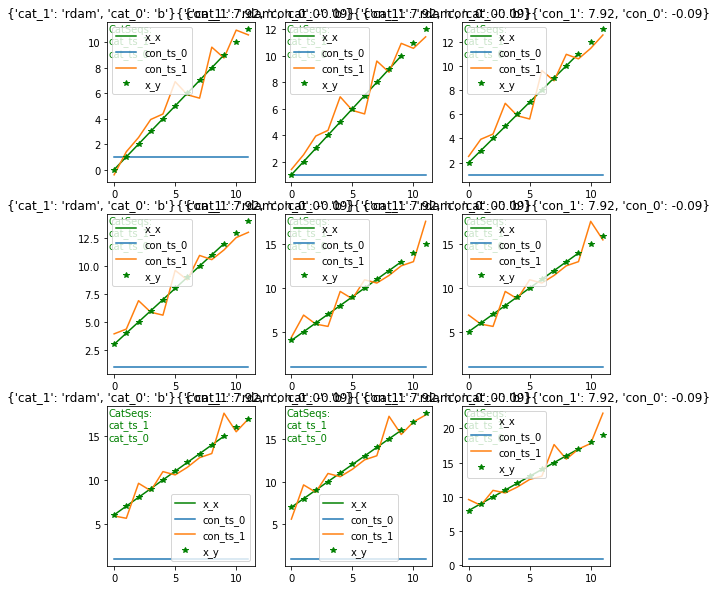

In [85]:
horizon,lookback = 2,9
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2,)
dl.show_batch()

In [86]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [87]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [88]:
a = TensorSeq([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,nan,nan,'00:01']


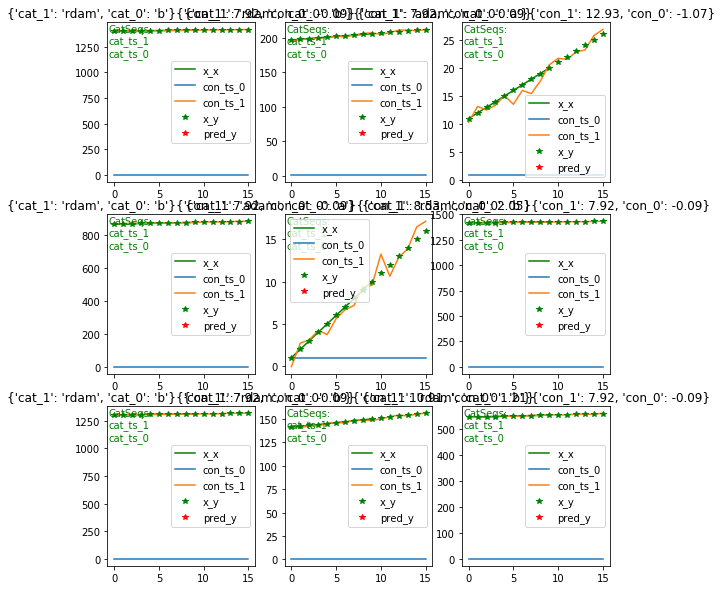

In [96]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.ones(in_f,in_f+out_f)), nn.Parameter(torch.zeros(in_f+out_f))
    def forward(self, x,*args): 
        assert x.shape[1:] == (1,10), x
        return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)

horizon,lookback = 6, 10
df = get_df([160, 160, 160])
save_df(df, path)
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)

learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))
learn.fit(1)
learn.show_results(max_n=9)

(#4) [0,nan,nan,'00:02']


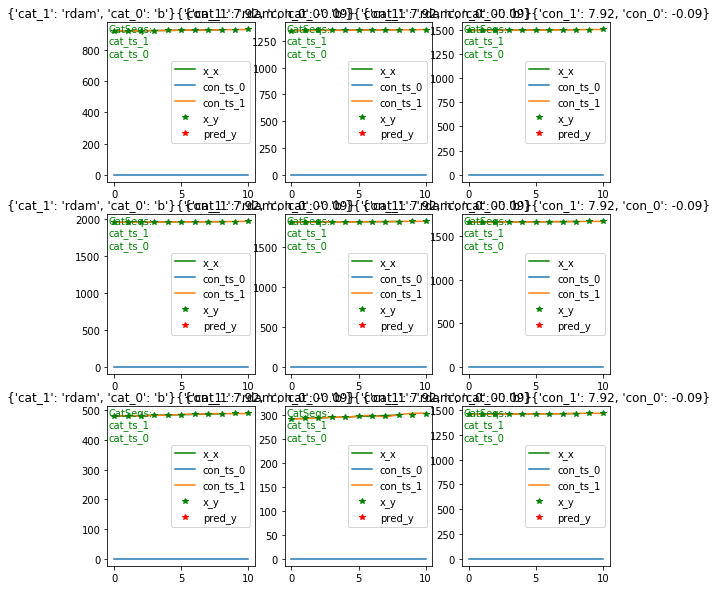

In [97]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)
learn.show_results(max_n=9)

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.m5.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.


In [102]:
git_add('02_data.load.ipynb', commit_msg='get_df')

Converted 02_data.load.ipynb.


['/home/tako/dev/fastseq/fastseq/data/load.py',
 '/home/tako/dev/fastseq/nbs/02_data.load.ipynb']